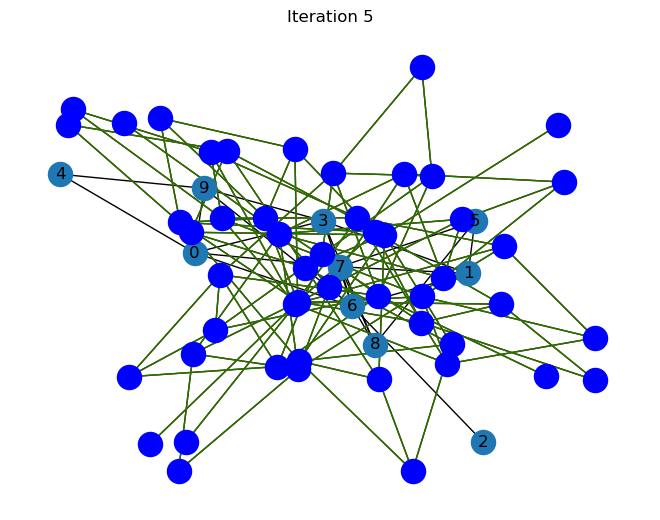

In [1]:
class EGNNEncoder(nn.Module):
    
    def __init__(self, args, node_hdim=0, features_type='backbone', update_X=True):
        super(EGNNEncoder, self).__init__()
        self.update_X = update_X
        self.features_type = features_type
        self.features = ProteinFeatures(
                top_k=args.k_neighbors, num_rbf=args.num_rbf,
                features_type=features_type,
                direction='bidirectional'
        )
        self.node_in, self.edge_in = self.features.feature_dimensions[features_type]
        self.node_in += node_hdim
        
        self.W_v = nn.Linear(self.node_in, args.hidden_size)
        self.W_e = nn.Linear(self.edge_in, args.hidden_size)
        self.layers = nn.ModuleList([
                MPNNLayer(args.hidden_size, args.hidden_size * 3, dropout=args.dropout)
                for _ in range(args.depth)
        ])
        if self.update_X:
            self.W_x = nn.Linear(args.hidden_size, args.hidden_size)
            self.U_x = nn.Linear(args.hidden_size, args.hidden_size)
            self.T_x = nn.Sequential(nn.ReLU(), nn.Linear(args.hidden_size, 14))

        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

class HierEGNNEncoder(nn.Module):

    def __init__(self, args, update_X=True, backbone_CA_only=True):
        super(HierEGNNEncoder, self).__init__()
        self.update_X = update_X
        self.backbone_CA_only = backbone_CA_only
        self.clash_step = args.clash_step
        self.residue_mpn = EGNNEncoder(
                args, features_type='backbone',
                node_hdim=args.hidden_size,
                update_X=False,
        )
        self.atom_mpn = EGNNEncoder(
                args, features_type='atom',
                node_hdim=args.hidden_size,
                update_X=False,
        )
        if self.update_X:
            # backbone coord update
            self.W_x = nn.Linear(args.hidden_size, args.hidden_size)
            self.U_x = nn.Linear(args.hidden_size, args.hidden_size)
            self.T_x = nn.Sequential(nn.ReLU(), nn.Linear(args.hidden_size, 4))
            # side chain coord update
            self.W_a = nn.Linear(args.hidden_size, args.hidden_size)
            self.U_a = nn.Linear(args.hidden_size, args.hidden_size)
            self.T_a = nn.Sequential(nn.ReLU(), nn.Linear(args.hidden_size, 1))

        self.embedding = nn.Embedding(len(ATOM_TYPES), args.hidden_size)
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

class Normalize(nn.Module):

    def __init__(self, features, epsilon=1e-6):
        super(Normalize, self).__init__()
        self.gain = nn.Parameter(torch.ones(features))
        self.bias = nn.Parameter(torch.zeros(features))
        self.epsilon = epsilon

class MPNNLayer(nn.Module):

    def __init__(self, num_hidden, num_in, dropout):
        super(MPNNLayer, self).__init__()
        self.num_hidden = num_hidden
        self.num_in = num_in
        self.dropout = nn.Dropout(dropout)
        self.norm = nn.Identity() #Normalize(num_hidden)
        self.W = nn.Sequential(
                nn.Linear(num_hidden + num_in, num_hidden),
                nn.ReLU(),
                nn.Linear(num_hidden, num_hidden),
                nn.ReLU(),
                nn.Linear(num_hidden, num_hidden),
        )

class PosEmbedding(nn.Module):

    def __init__(self, num_embeddings):
        super(PosEmbedding, self).__init__()
        self.num_embeddings = num_embeddings

class AAEmbedding(nn.Module):

    def __init__(self):
        super(AAEmbedding, self).__init__()
        self.hydropathy = {'#': 0, "I":4.5, "V":4.2, "L":3.8, "F":2.8, "C":2.5, "M":1.9, "A":1.8, "W":-0.9, "G":-0.4, "T":-0.7, "S":-0.8, "Y":-1.3, "P":-1.6, "H":-3.2, "N":-3.5, "D":-3.5, "Q":-3.5, "E":-3.5, "K":-3.9, "R":-4.5}
        self.volume = {'#': 0, "G":60.1, "A":88.6, "S":89.0, "C":108.5, "D":111.1, "P":112.7, "N":114.1, "T":116.1, "E":138.4, "V":140.0, "Q":143.8, "H":153.2, "M":162.9, "I":166.7, "L":166.7, "K":168.6, "R":173.4, "F":189.9, "Y":193.6, "W":227.8}
        self.charge = {**{'R':1, 'K':1, 'D':-1, 'E':-1, 'H':0.1}, **{x:0 for x in 'ABCFGIJLMNOPQSTUVWXYZ#'}}
        self.polarity = {**{x:1 for x in 'RNDQEHKSTY'}, **{x:0 for x in "ACGILMFPWV#"}}
        self.acceptor = {**{x:1 for x in 'DENQHSTY'}, **{x:0 for x in "RKWACGILMFPV#"}}
        self.donor = {**{x:1 for x in 'RKWNQHSTY'}, **{x:0 for x in "DEACGILMFPV#"}}
        self.embedding = torch.tensor([
            [self.hydropathy[aa], self.volume[aa] / 100, self.charge[aa],
            self.polarity[aa], self.acceptor[aa], self.donor[aa]]
            for aa in ALPHABET
        ]).cuda()

class ABModel(nn.Module):

    def __init__(self, args):
        super(ABModel, self).__init__()
        self.k_neighbors = args.k_neighbors
        self.hidden_size = args.hidden_size
        self.embedding = AAEmbedding()
        self.features = ProteinFeatures(
                top_k=args.k_neighbors, num_rbf=args.num_rbf,
                features_type='full',
                direction='bidirectional'
        )
        self.W_i = nn.Linear(self.embedding.dim(), args.hidden_size)
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')
        self.mse_loss = nn.MSELoss(reduction='none')
        self.huber_loss = nn.SmoothL1Loss(reduction='none')

class PositionalEncodings(nn.Module):

    def __init__(self, num_embeddings, period_range=[2,1000]):
        super(PositionalEncodings, self).__init__()
        self.num_embeddings = num_embeddings
        self.period_range = period_range 

class ProteinFeatures(nn.Module):

    def __init__(self, num_positional_embeddings=16, num_rbf=16, top_k=30, features_type='backbone', direction='forward'):
        """ Extract protein features """
        super(ProteinFeatures, self).__init__()
        self.top_k = top_k
        self.num_rbf = num_rbf
        self.num_positional_embeddings = num_positional_embeddings
        self.direction = direction

        # Feature types
        self.features_type = features_type
        self.feature_dimensions = {
            'atom': (0, num_positional_embeddings + num_rbf),
            'backbone': (6, num_positional_embeddings + num_rbf + 7),
        }

        # Positional encoding
        self.embeddings = PositionalEncodings(num_positional_embeddings)

class AntibodyComplexDataset():

    def __init__(self, jsonl_file, cdr_type, L_target):
        self.data = []
        with open(jsonl_file) as f:
            all_lines = f.readlines()
            for line in tqdm(all_lines):
                entry = json.loads(line)
                assert len(entry['antibody_coords']) == len(entry['antibody_seq'])
                assert len(entry['antigen_coords']) == len(entry['antigen_seq'])
                if entry['antibody_cdr'].count(cdr_type) <= 4:
                    continue

                # paratope region
                surface = torch.tensor(
                        [i for i,v in enumerate(entry['antibody_cdr']) if v in cdr_type]
                )
                entry['binder_surface'] = surface

                entry['binder_seq'] = ''.join([entry['antibody_seq'][i] for i in surface.tolist()])
                entry['binder_coords'] = torch.tensor(entry['antibody_coords'])[surface]
                entry['binder_atypes'] = torch.tensor(
                        [[ATOM_TYPES.index(a) for a in RES_ATOM14[ALPHABET.index(s)]] for s in entry['binder_seq']]
                )
                mask = (entry['binder_coords'].norm(dim=-1) > 1e-6).long()
                entry['binder_atypes'] *= mask

                # Create target
                entry['target_seq'] = entry['antigen_seq']
                entry['target_coords'] = torch.tensor(entry['antigen_coords'])
                entry['target_atypes'] = torch.tensor(
                        [[ATOM_TYPES.index(a) for a in RES_ATOM14[ALPHABET.index(s)]] for s in entry['target_seq']]
                )
                mask = (entry['target_coords'].norm(dim=-1) > 1e-6).long()
                entry['target_atypes'] *= mask

                # Find target surface
                dist, _ = full_square_dist(
                        entry['target_coords'][None,...], 
                        entry['binder_coords'][None,...], 
                        entry['target_atypes'][None,...], 
                        entry['binder_atypes'][None,...], 
                        contact=True
                )
                K = min(len(dist[0]), L_target)
                epitope = dist[0].amin(dim=-1).topk(k=K, largest=False).indices
                entry['target_surface'] = torch.sort(epitope).values

                if len(entry['binder_coords']) > 4 and len(entry['target_coords']) > 4 and entry['antibody_cdr'].count('001') <= 1:
                    self.data.append(entry)

class ComplexLoader():

    def __init__(self, dataset, batch_tokens):
        self.dataset = dataset
        self.size = len(dataset)
        self.lengths = [len(dataset[i]['binder_seq']) for i in range(self.size)]
        self.batch_tokens = batch_tokens
        sorted_ix = np.argsort(self.lengths)

        # Cluster into batches of similar sizes
        clusters, batch = [], []
        for ix in sorted_ix:
            size = self.lengths[ix]
            batch.append(ix)
            if size * (len(batch) + 1) > self.batch_tokens:
                clusters.append(batch)
                batch = []

        self.clusters = clusters
        if len(batch) > 0:
            clusters.append(batch)

class RefineDocker(ABModel):

    def __init__(self, args):
        super(RefineDocker, self).__init__(args)
        self.rstep = args.rstep
        self.U_i = nn.Linear(self.embedding.dim(), args.hidden_size)
        self.target_mpn = EGNNEncoder(args, update_X=False)
        self.hierarchical = args.hierarchical
        if args.hierarchical:
            self.struct_mpn = HierEGNNEncoder(args)
        else:
            self.struct_mpn = EGNNEncoder(args)

        self.W_x0 = nn.Sequential(
                nn.Linear(args.hidden_size, args.hidden_size),
                nn.ReLU(),
                nn.Linear(args.hidden_size, args.hidden_size)
        )
        self.U_x0 = nn.Sequential(
                nn.Linear(args.hidden_size, args.hidden_size),
                nn.ReLU(),
                nn.Linear(args.hidden_size, args.hidden_size)
        )
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

class CondRefineDecoder(ABModel):

    def __init__(self, args):
        super(CondRefineDecoder, self).__init__(args)
        self.hierarchical = args.hierarchical
        self.residue_atom14 = torch.tensor([
                [ATOM_TYPES.index(a) for a in atoms] for atoms in RES_ATOM14
        ]).cuda()

        self.W_s0 = nn.Sequential(
                PosEmbedding(32),
                nn.Linear(32, args.hidden_size),
                nn.ReLU(),
                nn.Linear(args.hidden_size, len(ALPHABET))
        )
        self.W_x0 = nn.Sequential(
                PosEmbedding(32),
                nn.Linear(32, args.hidden_size),
                nn.ReLU(),
                nn.Linear(args.hidden_size, args.hidden_size)
        )
        self.U_x0 = nn.Sequential(
                nn.Linear(args.hidden_size, args.hidden_size),
                nn.ReLU(),
                nn.Linear(args.hidden_size, args.hidden_size)
        )
        self.W_s = nn.Linear(args.hidden_size, len(ALPHABET))
        self.U_i = nn.Linear(self.embedding.dim(), args.hidden_size)
        self.target_mpn = EGNNEncoder(args, update_X=False)

        if args.hierarchical:
            self.struct_mpn = HierEGNNEncoder(args)
            self.seq_mpn = HierEGNNEncoder(args, update_X=False, backbone_CA_only=False)
        else:
            self.struct_mpn = EGNNEncoder(args)
            self.seq_mpn = EGNNEncoder(args, update_X=False)

        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

class AttRefineDecoder(ABModel):

    def __init__(self, args):
        super(AttRefineDecoder, self).__init__(args)
        self.W_x = nn.Linear(args.hidden_size, 42)
        self.W_s = nn.Linear(args.hidden_size * 2, len(ALPHABET))
        self.struct_mpn = EGNNEncoder(args, update_X=False)
        self.seq_mpn = EGNNEncoder(args, update_X=False)
        self.W_x0 = nn.Sequential(
                PosEmbedding(32),
                nn.Linear(32, args.hidden_size),
                nn.ReLU(),
                nn.Linear(args.hidden_size, 42)
        )
        self.U_i = nn.Linear(self.embedding.dim(), args.hidden_size)
        self.target_mpn = EGNNEncoder(args, update_X=False)
        self.W_att = nn.Sequential(
                nn.Linear(args.hidden_size * 2, args.hidden_size),
                nn.ReLU(),
        )
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

class UncondRefineDecoder(ABModel):

    def __init__(self, args):
        super(UncondRefineDecoder, self).__init__(args)
        self.W_x = nn.Linear(args.hidden_size, 42)
        self.W_s = nn.Linear(args.hidden_size, len(ALPHABET))
        self.struct_mpn = EGNNEncoder(args, update_X=False)
        self.seq_mpn = EGNNEncoder(args, update_X=False)
        self.W_x0 = nn.Sequential(
                PosEmbedding(32),
                nn.Linear(32, args.hidden_size),
                nn.ReLU(),
                nn.Linear(args.hidden_size, 42)
        )
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)

class SequenceDecoder(ABModel):

    def __init__(self, args):
        super(SequenceDecoder, self).__init__(args)
        self.no_target = args.no_target
        self.W_s = nn.Linear(args.hidden_size, len(ALPHABET))
        self.seq_rnn = SRUpp(
                args.hidden_size,
                args.hidden_size,
                args.hidden_size // 2,
                num_layers=args.depth,
                dropout=args.dropout,
                bidirectional=False,
        )
        if not self.no_target:
            self.U_i = nn.Linear(self.embedding.dim(), args.hidden_size)
            self.W_s = nn.Linear(args.hidden_size * 2, len(ALPHABET))
            self.target_mpn = EGNNEncoder(args, update_X=False)
            self.W_att = nn.Sequential(
                    nn.Linear(args.hidden_size * 2, args.hidden_size),
                    nn.ReLU(),
            )
        for param in self.parameters():
            if param.dim() > 1:
                nn.init.xavier_uniform_(param)






class PositionalEncodings(nn.Module):

    def __init__(self, num_embeddings, period_range=[2,1000]):
        super(PositionalEncodings, self).__init__()
        self.num_embeddings = num_embeddings
        self.period_range = period_range 

    def forward(self, E_idx):
        # i-j
        N_batch = E_idx.size(0)
        N_nodes = E_idx.size(1)
        N_neighbors = E_idx.size(2)
        ii = torch.arange(N_nodes, dtype=torch.float32).view((1, -1, 1)).cuda()
        d = (E_idx.float() - ii).unsqueeze(-1)
        # Original Transformer frequencies
        frequency = torch.exp(
            torch.arange(0, self.num_embeddings, 2, dtype=torch.float32)
            * -(np.log(10000.0) / self.num_embeddings)
        ).cuda()
        # Grid-aligned
        # frequency = 2. * np.pi * torch.exp(
        #     -torch.linspace(
        #         np.log(self.period_range[0]), 
        #         np.log(self.period_range[1]),
        #         self.num_embeddings / 2
        #     )
        # )
        angles = d * frequency.view((1,1,1,-1))
        E = torch.cat((torch.cos(angles), torch.sin(angles)), -1)
        return E

class ProteinFeatures(nn.Module):

    def __init__(self, num_positional_embeddings=16, num_rbf=16, top_k=30, features_type='backbone', direction='forward'):
        """ Extract protein features """
        super(ProteinFeatures, self).__init__()
        self.top_k = top_k
        self.num_rbf = num_rbf
        self.num_positional_embeddings = num_positional_embeddings
        self.direction = direction

        # Feature types
        self.features_type = features_type
        self.feature_dimensions = {
            'atom': (0, num_positional_embeddings + num_rbf),
            'backbone': (6, num_positional_embeddings + num_rbf + 7),
        }

        # Positional encoding
        self.embeddings = PositionalEncodings(num_positional_embeddings)
        
    def _dist(self, X, mask, eps=1E-6):
        """ Pairwise euclidean distances """
        N = X.size(1)
        mask_2D = torch.unsqueeze(mask,1) * torch.unsqueeze(mask,2)
        if self.direction == 'bidirectional':
            mask_2D = mask_2D - torch.eye(N).unsqueeze(0).cuda()  # remove self
            mask_2D = mask_2D.clamp(min=0)
        elif self.direction == 'forward':
            nmask = torch.arange(X.size(1)).cuda()
            nmask = nmask.view(1,-1,1) > nmask.view(1,1,-1)
            mask_2D = nmask.float() * mask_2D  # [B, N, N]
        else:
            raise ValueError('invalid direction', direction)

        dX = torch.unsqueeze(X,1) - torch.unsqueeze(X,2)
        D = mask_2D * torch.sqrt(torch.sum(dX**2, 3) + eps)

        # Identify k nearest neighbors (not including self)
        D_adjust = D + (1. - mask_2D) * 10000
        top_k = min(self.top_k, N)
        D_neighbors, E_idx = torch.topk(D_adjust, top_k, dim=-1, largest=False)
        mask_neighbors = gather_edges(mask_2D.unsqueeze(-1), E_idx)

        # Debug plot KNN
        # print(E_idx[:10,:10])
        # D_simple = mask_2D * torch.zeros(D.size()).scatter(-1, E_idx, torch.ones_like(knn_D))
        # print(D_simple)
        # fig = plt.figure(figsize=(4,4))
        # ax = fig.add_subplot(111)
        # D_simple = D.data.numpy()[0,:,:]
        # plt.imshow(D_simple, aspect='equal')
        # plt.axis('off')
        # plt.tight_layout()
        # plt.savefig('D_knn.pdf')
        # exit(0)
        return D_neighbors, E_idx, mask_neighbors

    def _rbf(self, D):
        # Distance radial basis function
        D_min, D_max, D_count = 0., 20., self.num_rbf
        D_mu = torch.linspace(D_min, D_max, D_count).cuda()
        D_mu = D_mu.view([1,1,1,-1])
        D_sigma = (D_max - D_min) / D_count
        D_expand = torch.unsqueeze(D, -1)
        RBF = torch.exp(-((D_expand - D_mu) / D_sigma)**2)

        # for i in range(D_count):
        #     fig = plt.figure(figsize=(4,4))
        #     ax = fig.add_subplot(111)
        #     rbf_i = RBF.data.numpy()[0,i,:,:]
        #     # rbf_i = D.data.numpy()[0,0,:,:]
        #     plt.imshow(rbf_i, aspect='equal')
        #     plt.axis('off')
        #     plt.tight_layout()
        #     plt.savefig('rbf{}.pdf'.format(i))
        #     print(np.min(rbf_i), np.max(rbf_i), np.mean(rbf_i))
        # exit(0)
        return RBF

    def _quaternions(self, R):
        """ Convert a batch of 3D rotations [R] to quaternions [Q]
            R [...,3,3]
            Q [...,4]
        """
        # Simple Wikipedia version
        # en.wikipedia.org/wiki/Rotation_matrix#Quaternion
        # For other options see math.stackexchange.com/questions/2074316/calculating-rotation-axis-from-rotation-matrix
        diag = torch.diagonal(R, dim1=-2, dim2=-1)
        Rxx, Ryy, Rzz = diag.unbind(-1)
        magnitudes = 0.5 * torch.sqrt(torch.abs(1 + torch.stack([
              Rxx - Ryy - Rzz, 
            - Rxx + Ryy - Rzz, 
            - Rxx - Ryy + Rzz
        ], -1)))
        _R = lambda i,j: R[:,:,:,i,j]
        signs = torch.sign(torch.stack([
            _R(2,1) - _R(1,2),
            _R(0,2) - _R(2,0),
            _R(1,0) - _R(0,1)
        ], -1))
        xyz = signs * magnitudes
        # The relu enforces a non-negative trace
        w = torch.sqrt(F.relu(1 + diag.sum(-1, keepdim=True))) / 2.
        Q = torch.cat((xyz, w), -1)
        Q = F.normalize(Q, dim=-1)

        # Axis of rotation
        # Replace bad rotation matrices with identity
        # I = torch.eye(3).view((1,1,1,3,3))
        # I = I.expand(*(list(R.shape[:3]) + [-1,-1]))
        # det = (
        #     R[:,:,:,0,0] * (R[:,:,:,1,1] * R[:,:,:,2,2] - R[:,:,:,1,2] * R[:,:,:,2,1])
        #     - R[:,:,:,0,1] * (R[:,:,:,1,0] * R[:,:,:,2,2] - R[:,:,:,1,2] * R[:,:,:,2,0])
        #     + R[:,:,:,0,2] * (R[:,:,:,1,0] * R[:,:,:,2,1] - R[:,:,:,1,1] * R[:,:,:,2,0])
        # )
        # det_mask = torch.abs(det.unsqueeze(-1).unsqueeze(-1))
        # R = det_mask * R + (1 - det_mask) * I

        # DEBUG
        # https://math.stackexchange.com/questions/2074316/calculating-rotation-axis-from-rotation-matrix
        # Columns of this are in rotation plane
        # A = R - I
        # v1, v2 = A[:,:,:,:,0], A[:,:,:,:,1]
        # axis = F.normalize(torch.cross(v1, v2), dim=-1)
        return Q

    def _contacts(self, D_neighbors, E_idx, mask_neighbors, cutoff=8):
        """ Contacts """
        D_neighbors = D_neighbors.unsqueeze(-1)
        neighbor_C = mask_neighbors * (D_neighbors < cutoff).type(torch.float32)
        return neighbor_C

    def _hbonds(self, X, E_idx, mask_neighbors, eps=1E-3):
        """ Hydrogen bonds and contact map
        """
        X_atoms = dict(zip(['N', 'CA', 'C', 'O'], torch.unbind(X, 2)))

        # Virtual hydrogens
        X_atoms['C_prev'] = F.pad(X_atoms['C'][:,1:,:], (0,0,0,1), 'constant', 0)
        X_atoms['H'] = X_atoms['N'] + F.normalize(
             F.normalize(X_atoms['N'] - X_atoms['C_prev'], -1)
          +  F.normalize(X_atoms['N'] - X_atoms['CA'], -1)
        , -1)

        def _distance(X_a, X_b):
            return torch.norm(X_a[:,None,:,:] - X_b[:,:,None,:], dim=-1)

        def _inv_distance(X_a, X_b):
            return 1. / (_distance(X_a, X_b) + eps)

        # DSSP vacuum electrostatics model
        U = (0.084 * 332) * (
              _inv_distance(X_atoms['O'], X_atoms['N'])
            + _inv_distance(X_atoms['C'], X_atoms['H'])
            - _inv_distance(X_atoms['O'], X_atoms['H'])
            - _inv_distance(X_atoms['C'], X_atoms['N'])
        )

        HB = (U < -0.5).type(torch.float32)
        neighbor_HB = mask_neighbors * gather_edges(HB.unsqueeze(-1),  E_idx)
        # print(HB)
        # HB = F.sigmoid(U)
        # U_np = U.cpu().data.numpy()
        # # plt.matshow(np.mean(U_np < -0.5, axis=0))
        # plt.matshow(HB[0,:,:])
        # plt.colorbar()
        # plt.show()
        # D_CA = _distance(X_atoms['CA'], X_atoms['CA'])
        # D_CA = D_CA.cpu().data.numpy()
        # plt.matshow(D_CA[0,:,:] < contact_D)
        # # plt.colorbar()
        # plt.show()
        # exit(0)
        return neighbor_HB

    def _AD_features(self, X, eps=1e-6):
        # Shifted slices of unit vectors
        dX = X[:,1:,:] - X[:,:-1,:]
        U = F.normalize(dX, dim=-1)
        u_2 = U[:,:-2,:]
        u_1 = U[:,1:-1,:]
        u_0 = U[:,2:,:]
        # Backbone normals
        n_2 = F.normalize(torch.cross(u_2, u_1), dim=-1)
        n_1 = F.normalize(torch.cross(u_1, u_0), dim=-1)

        # Bond angle calculation
        cosA = -(u_1 * u_0).sum(-1)
        cosA = torch.clamp(cosA, -1+eps, 1-eps)
        A = torch.acos(cosA)
        # Angle between normals
        cosD = (n_2 * n_1).sum(-1)
        cosD = torch.clamp(cosD, -1+eps, 1-eps)
        D = torch.sign((u_2 * n_1).sum(-1)) * torch.acos(cosD)
        # Backbone features
        AD_features = torch.stack((torch.cos(A), torch.sin(A) * torch.cos(D), torch.sin(A) * torch.sin(D)), 2)
        return F.pad(AD_features, (0,0,1,2), 'constant', 0)

    def _orientations_coarse(self, X, E_idx, eps=1e-6):
        # Shifted slices of unit vectors
        dX = X[:,1:,:] - X[:,:-1,:]
        U = F.normalize(dX, dim=-1)
        u_2 = U[:,:-2,:]
        u_1 = U[:,1:-1,:]
        u_0 = U[:,2:,:]
        # Backbone normals
        n_2 = F.normalize(torch.cross(u_2, u_1), dim=-1)
        n_1 = F.normalize(torch.cross(u_1, u_0), dim=-1)

        # Build relative orientations
        o_1 = F.normalize(u_2 - u_1, dim=-1)
        O = torch.stack((o_1, n_2, torch.cross(o_1, n_2)), 2)
        O = O.view(list(O.shape[:2]) + [9])
        O = F.pad(O, (0,0,1,2), 'constant', 0)

        O_neighbors = gather_nodes(O, E_idx)
        X_neighbors = gather_nodes(X, E_idx)
        
        # Re-view as rotation matrices
        O = O.view(list(O.shape[:2]) + [3,3])
        O_neighbors = O_neighbors.view(list(O_neighbors.shape[:3]) + [3,3])

        # Rotate into local reference frames
        dX = X_neighbors - X.unsqueeze(-2)
        dU = torch.matmul(O.unsqueeze(2), dX.unsqueeze(-1)).squeeze(-1)
        dU = F.normalize(dU, dim=-1)
        R = torch.matmul(O.unsqueeze(2).transpose(-1,-2), O_neighbors)
        Q = self._quaternions(R)
        return torch.cat((dU,Q), dim=-1)

    def _dihedrals(self, X, eps=1e-7):
        # First 3 coordinates are N, CA, C
        X = X[:,:,:3,:].reshape(X.shape[0], 3*X.shape[1], 3)

        # Shifted slices of unit vectors
        dX = X[:,1:,:] - X[:,:-1,:]
        U = F.normalize(dX, dim=-1)
        u_2 = U[:,:-2,:]
        u_1 = U[:,1:-1,:]
        u_0 = U[:,2:,:]
        # Backbone normals
        n_2 = F.normalize(torch.cross(u_2, u_1), dim=-1)
        n_1 = F.normalize(torch.cross(u_1, u_0), dim=-1)

        # Angle between normals
        cosD = (n_2 * n_1).sum(-1)
        cosD = torch.clamp(cosD, -1+eps, 1-eps)
        D = torch.sign((u_2 * n_1).sum(-1)) * torch.acos(cosD)

        D = F.pad(D, (3,0), 'constant', 0)
        D = D.view((D.size(0), int(D.size(1)/3), 3))
        phi, psi, omega = torch.unbind(D,-1)

        # print(cosD.cpu().data.numpy().flatten())
        # print(omega.sum().cpu().data.numpy().flatten())

        # Bond angle calculation
        # A = torch.acos(-(u_1 * u_0).sum(-1))

        # DEBUG: Ramachandran plot
        # x = phi.cpu().data.numpy().flatten()
        # y = psi.cpu().data.numpy().flatten()
        # plt.scatter(x * 180 / np.pi, y * 180 / np.pi, s=1, marker='.')
        # plt.xlabel('phi')
        # plt.ylabel('psi')
        # plt.axis('square')
        # plt.grid()
        # plt.axis([-180,180,-180,180])
        # plt.show()

        # Lift angle representations to the circle
        D_features = torch.cat((torch.cos(D), torch.sin(D)), 2)
        return D_features

    def forward(self, X, mask):
        """ Featurize coordinates as an attributed graph """
        if self.features_type == 'backbone':
            X_ca = X[:,:,1,:]
            D_neighbors, E_idx, mask_neighbors = self._dist(X_ca, mask)
            RBF = self._rbf(D_neighbors)
            E_positional = self.embeddings(E_idx)
            O_features = self._orientations_coarse(X_ca, E_idx)
            E = torch.cat((E_positional, RBF, O_features), -1)
            V = self._dihedrals(X)

        elif self.features_type == 'atom':
            D_neighbors, E_idx, mask_neighbors = self._dist(X, mask)
            RBF = self._rbf(D_neighbors)
            E_positional = self.embeddings(E_idx)
            E = torch.cat((E_positional, RBF), -1)
            V = None

        return V, E, E_idx

class AAEmbedding(nn.Module):

    def __init__(self):
        super(AAEmbedding, self).__init__()
        self.hydropathy = {'#': 0, "I":4.5, "V":4.2, "L":3.8, "F":2.8, "C":2.5, "M":1.9, "A":1.8, "W":-0.9, "G":-0.4, "T":-0.7, "S":-0.8, "Y":-1.3, "P":-1.6, "H":-3.2, "N":-3.5, "D":-3.5, "Q":-3.5, "E":-3.5, "K":-3.9, "R":-4.5}
        self.volume = {'#': 0, "G":60.1, "A":88.6, "S":89.0, "C":108.5, "D":111.1, "P":112.7, "N":114.1, "T":116.1, "E":138.4, "V":140.0, "Q":143.8, "H":153.2, "M":162.9, "I":166.7, "L":166.7, "K":168.6, "R":173.4, "F":189.9, "Y":193.6, "W":227.8}
        self.charge = {**{'R':1, 'K':1, 'D':-1, 'E':-1, 'H':0.1}, **{x:0 for x in 'ABCFGIJLMNOPQSTUVWXYZ#'}}
        self.polarity = {**{x:1 for x in 'RNDQEHKSTY'}, **{x:0 for x in "ACGILMFPWV#"}}
        self.acceptor = {**{x:1 for x in 'DENQHSTY'}, **{x:0 for x in "RKWACGILMFPV#"}}
        self.donor = {**{x:1 for x in 'RKWNQHSTY'}, **{x:0 for x in "DEACGILMFPV#"}}
        self.embedding = torch.tensor([
            [self.hydropathy[aa], self.volume[aa] / 100, self.charge[aa],
            self.polarity[aa], self.acceptor[aa], self.donor[aa]]
            for aa in ALPHABET
        ]).cuda()

    def to_rbf(self, D, D_min, D_max, stride):
        D_count = int((D_max - D_min) / stride)
        D_mu = torch.linspace(D_min, D_max, D_count).cuda()
        D_mu = D_mu.view(1,1,-1)  # [1, 1, K]
        D_expand = torch.unsqueeze(D, -1)  # [B, N, 1]
        return torch.exp(-((D_expand - D_mu) / stride) ** 2)

    def transform(self, aa_vecs):
        return torch.cat([
            self.to_rbf(aa_vecs[:, :, 0], -4.5, 4.5, 0.1),
            self.to_rbf(aa_vecs[:, :, 1], 0, 2.2, 0.1),
            self.to_rbf(aa_vecs[:, :, 2], -1.0, 1.0, 0.25),
            torch.sigmoid(aa_vecs[:, :, 3:] * 6 - 3),
        ], dim=-1)

    def dim(self):
        return 90 + 22 + 8 + 3

    def forward(self, x, raw=False):
        B, N = x.size(0), x.size(1)
        aa_vecs = self.embedding[x.view(-1)].view(B, N, -1)
        rbf_vecs = self.transform(aa_vecs)
        return aa_vecs if raw else rbf_vecs

    def soft_forward(self, x):
        B, N = x.size(0), x.size(1)
        aa_vecs = torch.matmul(x.reshape(B * N, -1), self.embedding).view(B, N, -1)
        rbf_vecs = self.transform(aa_vecs)
        return rbf_vecs


class ABModel(nn.Module):

    def __init__(self, args):
        super(ABModel, self).__init__()
        self.k_neighbors = args.k_neighbors
        self.hidden_size = args.hidden_size
        self.embedding = AAEmbedding()
        self.features = ProteinFeatures(
                top_k=args.k_neighbors, num_rbf=args.num_rbf,
                features_type='full',
                direction='bidirectional'
        )
        self.W_i = nn.Linear(self.embedding.dim(), args.hidden_size)
        self.bce_loss = nn.BCEWithLogitsLoss(reduction='none')
        self.ce_loss = nn.CrossEntropyLoss(reduction='none')
        self.mse_loss = nn.MSELoss(reduction='none')
        self.huber_loss = nn.SmoothL1Loss(reduction='none')

    def select_target(self, tgt_X, tgt_h, tgt_A, tgt_pos):
        max_len = max([len(pos) for pos in tgt_pos])
        xlist = [tgt_X[i, pos] for i,pos in enumerate(tgt_pos)]
        hlist = [tgt_h[i, pos] for i,pos in enumerate(tgt_pos)]
        alist = [tgt_A[i, pos] for i,pos in enumerate(tgt_pos)]
        tgt_X = [F.pad(x, (0,0,0,0,0,max_len-len(x))) for x in xlist]
        tgt_h = [F.pad(h, (0,0,0,max_len-len(h))) for h in hlist]
        tgt_A = [F.pad(a, (0,0,0,max_len-len(a))) for a in alist]
        return torch.stack(tgt_X, dim=0), torch.stack(tgt_h, dim=0), torch.stack(tgt_A, dim=0)